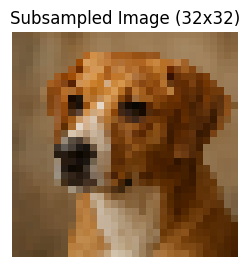

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# --- 1. SUBSAMPLING (Picking every 8th pixel) ---
# This method is fast but loses significant detail/causes aliasing [cite: 808, 935]
img_rgb = cv2.cvtColor(cv2.imread('./resources/dog256.png'), cv2.COLOR_BGR2RGB)
img_rgb_32_sub = np.zeros(shape=(32, 32, 3), dtype=np.uint8) 

for j in range(0, 32):
    for i in range(0, 32):
        for c in range(0, 3):
            # Pick exactly one pixel every 8 units [cite: 935]
            img_rgb_32_sub[i, j, c] = img_rgb[i*8, j*8, c] 
# Displaying the subsampled image
plt.subplot(1, 2, 1)
plt.title('Subsampled Image (32x32)')
plt.imshow(img_rgb_32_sub)
plt.axis('off')
plt.show()

In [16]:

# --- 2. DOWNSAMPLING (Averaging 2x2 blocks) ---
# This is superior to subsampling as it preserves more information 
def downsample_by_two(img_in, down_size: int = 2):
    h_input, w_input, c_input = img_in.shape 
    img_lr = np.zeros(shape=(h_input//down_size, w_input//down_size, c_input), dtype=np.uint8) 
    
    for j in range(0, h_input//down_size):
        for i in range(0, w_input//down_size):
            for c in range(0, c_input):
                # IMPORTANT: Cast to uint32 to avoid OVERFLOW during addition [cite: 809, 821, 947]
                
                # Compute integer average 
                avg = img_in[i*down_size:i*down_size+down_size, j*down_size:j*down_size+down_size, c].astype(np.uint32).mean()
                img_lr[i, j, c] = avg.astype(np.uint8) 
    return img_lr
img_rgb_down = downsample_by_two(img_rgb, down_size=1)
img_rgb_down1 = downsample_by_two(img_rgb, down_size=2)
img_rgb_down2 = downsample_by_two(img_rgb, down_size=3)
img_rgb_down3 = downsample_by_two(img_rgb, down_size=4)

# Displaying the downsampled image


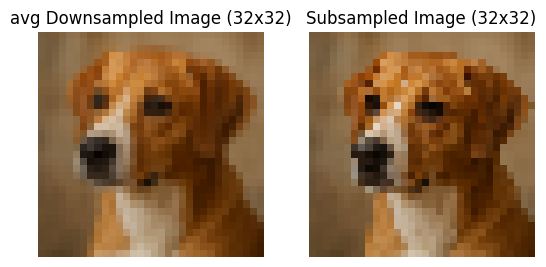

In [25]:
img_rgb_down8 = downsample_by_two(img_rgb, down_size=8)
plt.subplot(1, 2, 1)
plt.title('avg Downsampled Image (32x32)')
plt.imshow(img_rgb_down8)
plt.axis('off')
# plt.show()
# Displaying the subsampled image
plt.subplot(1, 2, 2)
plt.title('Subsampled Image (32x32)')
plt.imshow(img_rgb_32_sub)
plt.axis('off')
plt.show()

In [59]:
def conv2(img_in, box_size: int = 3, filter_value: int = 1):
    h_in, w_in, c_in = img_in.shape 
    img_out = np.zeros(shape=(h_in, w_in, c_in), dtype=np.uint8)
    
    # Calculate offset to center the kernel (e.g., if size is 5, offset is 2)
    offset = box_size // 2

    for c in range(0, 3): 
        # Avoid edges based on the kernel size 
        for j in range(offset, h_in - offset): 
            for i in range(offset, w_in - offset):
                sumpx = 0 
                for k in range(0, box_size): 
                    for l in range(0, box_size):
                        # Correct index: j + (k - offset) [cite: 984]
                        origpx = img_in[j + (k - offset), i + (l - offset), c].astype(np.uint32)
                        sumpx += origpx * filter_value 
                
                # Normalize by the total number of pixels in the box [cite: 986]
                img_out[j, i, c] = (sumpx // (box_size ** 2)).astype(np.uint8)
    return img_out

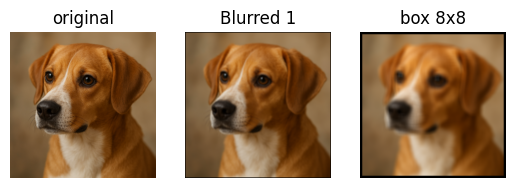

In [60]:
%%time
plt.subplot(1, 3, 1)
# img_conv_box = conv2(img_rgb, filter_value=1) # Box filter
plt.axis('off')
plt.imshow(img_rgb)
plt.title('original')

plt.subplot(1, 3, 2)
img_conv_box = conv2(img_rgb, box_size=3, filter_value=1) # Box filter
plt.axis('off')
plt.imshow(img_conv_box)
plt.title('Blurred 1')

plt.subplot(1, 3, 3)
box = 8
img_conv_box = conv2(img_rgb, box_size=box, filter_value=1.1) # Box filter
plt.imshow(img_conv_box)
plt.title(f'box {box}x{box}')
plt.axis('off')
plt.show()

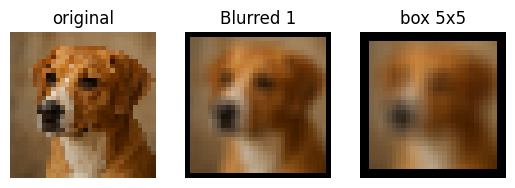

In [66]:
plt.subplot(1, 3, 1)
# img_conv_box = conv2(img_rgb, filter_value=1) # Box filter
plt.axis('off')
plt.imshow(img_rgb_32_sub)
plt.title('original')

plt.subplot(1, 3, 2)
img_conv_box = conv2(img_rgb_32_sub, box_size=3, filter_value=1) # Box filter
plt.axis('off')
plt.imshow(img_conv_box)
plt.title('Blurred 1')

plt.subplot(1, 3, 3)
box = 5
img_conv_box = conv2(img_rgb_32_sub, box_size=box, filter_value=1) # Box filter
plt.imshow(img_conv_box)
plt.title(f'box {box}x{box}')
plt.axis('off')
plt.show()

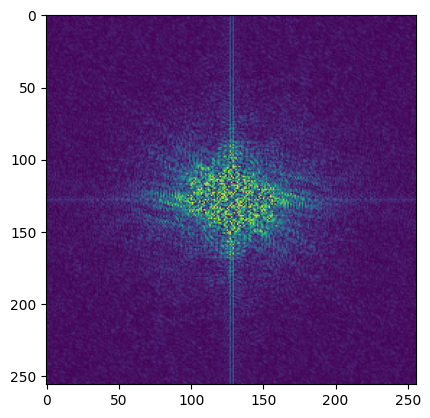

In [ ]:
# --- 4. FOURIER TRANSFORM (Frequency Domain) ---
# Used to analyze image frequencies (low-pass vs high-pass) 
# fft2: transform, fftshift: move zero-frequency to center 
f_dog = np.fft.fftshift(np.fft.fft2(img_rgb[:,:,0].astype(float))) / 64 
# np.abs is used because Fourier output is complex numbers 
plt.imshow(np.abs(f_dog).astype(np.uint8)) 
plt.show()